In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', None)
pd.set_option('future.no_silent_downcasting', True)
sns.set()

df = pd.read_csv('data_part_2.csv')

print(df.shape)
df.head()

(1009, 18)


,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,final_price,time_of_day,sold
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,night,1
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,NaN,morning,0
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,NaN,night,0
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,NaN,evening,0
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,NaN,day,0


# Set Proper Data Types

In [2]:
dtype_mapping = {
    'user_id': 'int64', 
    'region': 'object', 
    'device': 'object', 
    'channel': 'object', 
    'session_start': 'datetime64[ns]', 
    'session_end': 'datetime64[ns]', 
    'sessiondurationsec': 'float64', 
    'session_date': 'datetime64[ns]', 
    'month': 'int64', 
    'day': 'int64', 
    'hour_of_day': 'int64', 
    'order_dt': 'datetime64[ns]', 
    'revenue': 'float64', 
    'payment_type': 'object', 
    'promo_code': 'float64'
}

df = df.astype(dtype_mapping)

# 1. Data Preparation:

In [3]:
def prepare_channel_order_values(df):
    """
    Prepares order values by channel.
    """
    # Get only actual purchases (non-NaN revenue)
    orders = df[df['revenue'].notna()].copy()
    
    print("Channel order counts:")
    print(orders['channel'].value_counts())
    print("\nSummary statistics by channel:")
    print(orders.groupby('channel')['revenue'].agg(['count', 'mean', 'median']))
    
    return orders[['channel', 'revenue']]

orders_data = prepare_channel_order_values(df)

Channel order counts:
channel
социальные сети        113
organic                 88
контекстная реклама     45
реклама у блогеров      29
email-рассылки           7
Name: count, dtype: int64

Summary statistics by channel:
                     count         mean  median
channel                                        
email-рассылки           7  5427.571429  4999.0
organic                 88  5692.181818  4999.0
контекстная реклама     45  5310.111111  4999.0
реклама у блогеров      29  5792.103448  4999.0
социальные сети        113  5662.716814  4999.0


# Test normality for each channel:


Normality test results:
               channel  n_orders         mean  shapiro_stat       p_value  normal
0      социальные сети       113  5662.716814      0.495968  5.890494e-18   False
1              organic        88  5692.181818      0.509059  1.176987e-15   False
2   реклама у блогеров        29  5792.103448      0.547179  2.512990e-08   False
3       email-рассылки         7  5427.571429      0.664436  1.497441e-03   False
4  контекстная реклама        45  5310.111111      0.402342  2.687390e-12   False


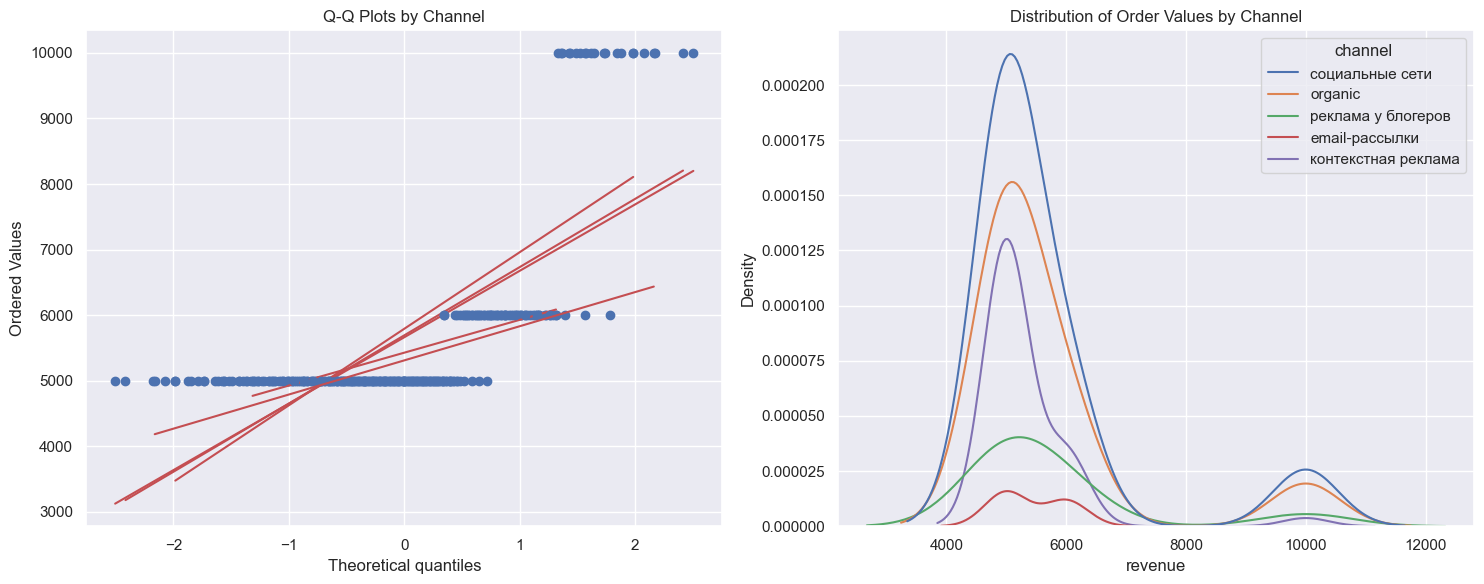

In [4]:
def test_channel_order_normality(orders):
    """
    Tests normality of order values for each channel.
    """
    results = []
    for channel in orders['channel'].unique():
        channel_values = orders[orders['channel'] == channel]['revenue']
        
        # Shapiro-Wilk test
        stat, pval = stats.shapiro(channel_values)
        
        results.append({
            'channel': channel,
            'n_orders': len(channel_values),
            'mean': channel_values.mean(),
            'shapiro_stat': stat,
            'p_value': pval,
            'normal': pval > 0.05
        })
    
    return pd.DataFrame(results)

normality_results = test_channel_order_normality(orders_data)
print("\nNormality test results:")
print(normality_results)

# Visualize distributions
plt.figure(figsize=(15, 6))

# QQ plot
plt.subplot(1, 2, 1)
for channel in orders_data['channel'].unique():
    values = orders_data[orders_data['channel'] == channel]['revenue']
    stats.probplot(values, dist="norm", plot=plt)
plt.title('Q-Q Plots by Channel')

# Density plot
plt.subplot(1, 2, 2)
sns.kdeplot(data=orders_data, x='revenue', hue='channel')
plt.title('Distribution of Order Values by Channel')
plt.tight_layout()
plt.show()

In [5]:
def test_channel_order_values(orders):
    """
    Tests differences in order values across channels using Kruskal-Wallis test.
    """
    # Kruskal-Wallis test
    channels = [group['revenue'].values 
               for _, group in orders.groupby('channel')]
    
    stat, pval = stats.kruskal(*channels)
    
    # Get summary statistics
    channel_stats = orders.groupby('channel')['revenue'].agg(['count', 'mean', 'median'])
    
    return {
        'statistic': stat,
        'p_value': pval,
        'significant': pval < 0.05,
        'channel_stats': channel_stats
    }

results = test_channel_order_values(orders_data)
print("\nKruskal-Wallis test results:")
print(f"Statistic: {results['statistic']:.4f}")
print(f"P-value: {results['p_value']:.4f}")
print(f"Significant: {results['significant']}")
print("\nChannel statistics:")
print(results['channel_stats'])


Kruskal-Wallis test results:
Statistic: 3.0665
P-value: 0.5468
Significant: False

Channel statistics:
                     count         mean  median
channel                                        
email-рассылки           7  5427.571429  4999.0
organic                 88  5692.181818  4999.0
контекстная реклама     45  5310.111111  4999.0
реклама у блогеров      29  5792.103448  4999.0
социальные сети        113  5662.716814  4999.0


Statistical test shows no significant differences in order values across channels (p = 0.5468 > 0.05)
Looking at the data:

All channels have identical median order values (4999.0)
Mean order values are similar across channels (range: 5310-5792)
Sample sizes vary considerably:

социальные сети: 113 orders
organic: 88 orders
контекстная реклама: 45 orders
реклама у блогеров: 29 orders
email-рассылки: 7 orders





Therefore:
Order values do NOT significantly differ by advertising channel. This suggests that regardless of how customers find the product (through social media, organic search, contextual advertising, bloggers, or email), they tend to make purchases of similar values. This could indicate that pricing and product offerings are consistent across marketing channels, and different channels don't attract significantly different spending behaviors.